In [1]:
import os
from dotenv import load_dotenv
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings,ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.schema import Document
from langchain import hub

from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field

from typing import List



USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
#load enviornmental variable
load_dotenv()

#key setup
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [3]:
#.load()
#Load Document
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs=[WebBaseLoader(url).load() for url in urls]



1. Create Retriver
2. create route function to check if the vectorstore have the document relevent to question
3. check if document is relevent generate answer (generation function) if not transform query
4. check if answer is hellusinating or not if not and if answer is relevent end
5. if hellucinating send generate again answer, if not relevent transform query


In [4]:
#.split_documents(), .from_documents, .as_retriver
#split the document
doc_list=[doc for sublist in docs for doc in sublist]
text_spliter=RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
split_doc=text_spliter.split_documents(doc_list)
#embedding and then creation of vector database
Embedding=OpenAIEmbeddings()
vectorstore=FAISS.from_documents(documents=split_doc, embedding=Embedding)
#Retriver
retriever=vectorstore.as_retriever()

In [5]:
class RouteQuery(BaseModel):
    route_selection:Literal["vectorstore","Websearch"]=Field(
        discription="Decide weather to use vectorstore or websearch")


llm=ChatOpenAI(model="gpt-4o-mini")
llm_withstructure=llm.with_structured_output(RouteQuery)

sys="""You are an assistant that decides the best source for answering a user’s question.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt=ChatPromptTemplate.from_messages([
    ("system",sys),
    ("human","the user question is {question}")
    ])

route_llm= route_prompt|llm_withstructure

In [6]:
class GradeDocRelevant(BaseModel):
    doc_relevant : Literal["relevant", "irrelevant"] = Field(
        description="Decide if the retrieved document from the vectorstore is relevant to the question. Select either 'relevant' or 'irrelevant'."
    )

sys = """You are a grader assessing the relevance of a retrieved document to a user's question.
If the retrieved document contains keywords or semantic meaning related to the question, grade it as 'relevant'. 
Otherwise, grade it as 'irrelevant'.
The goal is to filter out unrelated documents.
"""

DocRelevance_Prompt = ChatPromptTemplate.from_messages([
    ("system", sys),
    ("human", "User question:\n{question}\n\nDocument content:\n{document}")
])

llm_withstructure = llm.with_structured_output(GradeDocRelevant)

Doc_relevance_llm = DocRelevance_Prompt | llm_withstructure

In [7]:
class TransformedQuery(BaseModel):
    query: str = Field(description="Rewrite the question to improve clarity")

# System prompt
sys_prompt = """
You are an expert at rewriting user queries to improve clarity and optimize them for vectorstore retrieval.
Analyze the input question and rewrite it to capture the true semantic intent.
Return only the improved and retrieval-ready query.
"""

# ChatPrompt
transformed_prompt = ChatPromptTemplate.from_messages([
    ("system", sys_prompt),
    ("human", "User question:\n{question}")
])

# Structured LLM
llm_withstructure = llm.with_structured_output(TransformedQuery)

# Final LLM chain
transformed_query_llm = transformed_prompt | llm_withstructure



In [8]:
websearch_tool=TavilySearchResults(k=3)

/var/folders/77/58cswsf121l0qymv21qbtb500000gn/T/ipykernel_35128/2998626336.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  websearch_tool=TavilySearchResults(k=3)


In [9]:
#Generate 
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

generate_llm=prompt| llm| StrOutputParser()


In [10]:
#Hellucination
class GradeHellucination(BaseModel):
    binary_response:Literal["yes", "no"]=Field(description="Decide if the llm generation is grounded in the facts")

llm_withstructure=llm.with_structured_output(GradeHellucination)

sys="""You are an AI assistant that help in deciding, whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

Hellucination_prompt=ChatPromptTemplate([
    ("system", sys),
    ("human", "The answer is:{generation}, \n\n supporting documents are: {documents}")
])

hellucination_llm=Hellucination_prompt|llm_withstructure


In [11]:
#Answer Relevance
class GradeAnswerRelevance(BaseModel):
    binary_response:Literal["yes", "no"]=Field(description="Answer addresses the question, 'yes' or 'no'")

llm_withstructure=llm.with_structured_output(GradeAnswerRelevance)

sys="""You are a grader decide weather the answer resolve the question or not. 'yes, means the answer resolve the question."""

relevant_prompt=ChatPromptTemplate([
    ("system", sys),
    ("human", "The answer is:{generation}, \n\n the question is: {question}")
])

relevant_llm=relevant_prompt|llm_withstructure

In [17]:
#Define Nodes
class State(TypedDict):
    question:str
    documents:List[str]
    generation:str


def retrieve(state:State):
    question = state["question"]
    retrieve_doc=retriever.invoke(state["question"])
    return {"documents":retrieve_doc, "question":question}


def route(state:State):
    route_decision=route_llm.invoke({"question":state["question"]})
    if route_decision.route_selection=="vectorstore":
        return "vectorstore"
    
    elif route_decision.route_selection=="Websearch":
        return "Websearch"

def docRelevence(state:State):
    question = state["question"]
    documents = state["documents"]
    # Score each doc
    filtered_docs = []
    for d in documents:
        score = Doc_relevance_llm.invoke(
            {"question": question, "document": d.page_content}
        )
        grade=score.doc_relevant
        if grade == "relevant":
            filtered_docs.append(d)
        else:
            continue
    return {"documents": filtered_docs, "question": question}

    
    
def relevent_doc(state:State):
    filtered_documents = state["documents"]

    if not filtered_documents:
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transfer_query"
    else:
        print("---DECISION: GENERATE---")
        return "generate"

    
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def generate(state:State):
    question=state["question"]
    documents=state["documents"]
    context_text = format_docs(documents)
    answer=generate_llm.invoke({"context":context_text, "question":question})
    print("step3")
    return {"generation":answer, "question":question, "documents":documents}

def transfer_query(state:State):
    question=state["question"]
    documents=state["documents"]
    context_text = format_docs(documents)
    transformed_query=transformed_query_llm.invoke({"documents":context_text, "question":question})
    print("step4")
    return {"question":transformed_query.query, "documents":documents}


def web_search(state:State):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = websearch_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = [Document(page_content=web_results)]

    return {"documents": web_results, "question": question}


def conditions(state:State):
    hellucination_response= hellucination_llm.invoke({"generation":state["generation"], "documents":state["documents"]})
    relevance_response=relevant_llm.invoke({"generation":state["generation"], "question":state["question"]})

    if hellucination_response.binary_response=="yes":
        print("step7")
        if relevance_response.binary_response=="yes":
            return "useful_response"
        else:
            print("step9")
            return "transfer_query"
    else:
        print("step8")
        return "generate"
        


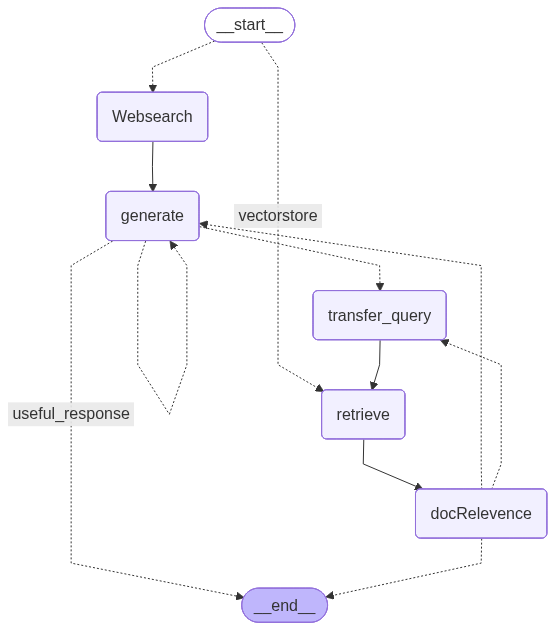

In [18]:
workflow=StateGraph(State)
workflow.add_node("retrieve", retrieve)
workflow.add_node("Websearch", web_search)
workflow.add_node("transfer_query", transfer_query)
workflow.add_node("generate", generate)
workflow.add_node("docRelevence", docRelevence)

workflow.add_conditional_edges(
    START, 
    route,
    {"vectorstore":"retrieve",
    "Websearch":"Websearch"}
    )

workflow.add_edge("retrieve","docRelevence")
workflow.add_edge("Websearch","generate")
workflow.add_conditional_edges(
    "docRelevence",
    relevent_doc,
    {"transfer_query":"transfer_query",
    "generate":"generate"}
    )
workflow.add_edge("transfer_query","retrieve")
workflow.add_conditional_edges(
    "generate",
    conditions,
    {"transfer_query":"transfer_query",
    "useful_response":END,
    "generate":"generate"})

app = workflow.compile()

from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [19]:
app.invoke({"question":"What is agent memory"})

---DECISION: GENERATE---
step3
step7


{'question': 'What is agent memory',
 'documents': [Document(id='4db12f4e-95f5-4a3f-a27e-d72c950536ef', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, lea

In [24]:
app.invoke({"question":"What is badminton?"})

---WEB SEARCH---
step3
step7


{'question': 'What is badminton?',
 'documents': [Document(metadata={}, page_content='Badminton is a racquet sport played using racquets "Racket (sports equipment)") to hit a shuttlecock across a net "Net (device)"). Although it may be played with larger teams, the most common forms of the game are "singles" (with one player per side) and "doubles" (with two players per side). Badminton is often played as a casual outdoor activity in a yard "Yard (land)") or on a beach; professional games are played on a rectangular indoor court. Points are scored by striking the shuttlecock [...] The game developed in British India from the earlier game of battledore and shuttlecock. European play came to be dominated by Denmark but the game has become very popular in Asia. In 1992, badminton debuted as a Summer Olympic sport with four events: men\'s singles, women\'s singles, men\'s doubles, and women\'s doubles; mixed doubles was added four years later. At high levels of play, the sport demands exce